In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
from Data import get_setup
import os
from datetime import datetime
import timeit

import torch.nn.functional as F
import torch
from torch import nn
from torch.utils.data import Dataset
from tqdm import trange
from Data import get_setup
from Inference_new import *
from Models.VI import *
from Tools import uniform_rect_sampler
import argparse


In [3]:
device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [4]:
## small ##
# predictive model architecture
layerwidth = 50
nblayers = 1
activation = nn.ReLU()



In [5]:
path="Results/Paper/Exp1/"

In [6]:
MODELS=torch.load(path+"Exp1_small2021-02-02-15:43boston_models.pt",map_location=device)
MODELS['concrete']=torch.load(path+"Exp1_small2021-02-02-15:43concrete_models.pt",map_location=device)['concrete']
MODELS['energy']=torch.load(path+"Exp1_small2021-02-02-15:56energy_models.pt",map_location=device)['energy']
MODELS['wine']=torch.load(path+"Exp1_small2021-02-02-16:08wine_models.pt",map_location=device)['wine']
MODELS['yacht']=torch.load(path+"Exp1_small2021-02-02-16:15yacht_models.pt",map_location=device)['yacht']


models_HMC = torch.load('Results/HMC_models.pt')


In [7]:
datasets = ['boston', 'concrete', 'energy','wine','yacht']
# for key in MODELS.keys():
#     datasets.append(key)

methods=['HMC','MC dropout','Ensemble','MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI']#[ 'MC dropout','Ensemble']
# for key in MODELS['energy'][0][1].keys():
#     methods.append(key)
    
datasets, methods

(['boston', 'concrete', 'energy', 'wine', 'yacht'],
 ['HMC',
  'MC dropout',
  'Ensemble',
  'MFVI',
  'FuNN-MFVI',
  'NN-HyVI',
  'FuNN-HyVI'])

In [8]:
from Metrics import rmse, lpp, lpp_gaussian
def get_metrics(y_pred, sigma_noise, y_test, std_y_train, time, gaussian_prediction=False):
    metrics = {}
    rmse_test, _ = rmse(y_pred.mean(dim=0).cpu(), y_test.cpu(), std_y_train.cpu())
    metrics.update({'RMSE': rmse_test})

    if gaussian_prediction:
        lpp_test, _ = lpp_gaussian(y_pred.cpu(), y_test.cpu(), sigma_noise.cpu(), std_y_train.cpu())
    else:
        lpp_test, _ = lpp(y_pred.cpu(), y_test.cpu(), sigma_noise.view(1, 1, 1).cpu(), std_y_train.cpu())

    metrics.update({'LPP': lpp_test})
    metrics.update({'time [s]': time})
    metrics.update({'std noise': sigma_noise.item()})
    return metrics

In [9]:
results=[]

for dataset in datasets:   

    for split in MODELS[dataset]:
        split_results={}
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']

        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=10).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test)
        metrics = get_metrics(y_pred, torch.tensor(0.), y_test, std_y_train, split[1][method][2], gaussian_prediction=True)
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model.predict(x_test, 1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2], gaussian_prediction=True)
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        
        
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        sigma_noise=model.sigma_noise
        predictor=model.predictor
        method='HMC'
        HMC_=models_HMC[dataset]
        indices = torch.randperm(len(HMC_))[:1000]
        theta=HMC_[indices].to(device)
        y_pred=predictor(x_test,theta)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train,'NA')
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        #Results.append({dataset:split_results})

In [11]:
torch.save(results,path+'_results.pt')
#results=torch.load(path+'_results.pt')

# RMSE

In [19]:
import pandas as pd

df=pd.DataFrame(results).loc[:,['dataset','method','RMSE']].groupby(['dataset','method']).mean()#.transpose()
df_sem=pd.DataFrame(results).loc[:,['dataset','method','RMSE']].groupby(['dataset','method']).sem()

def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: x[1])
    return df

df_=collapse_columns(df.unstack()).reindex(columns=methods)
df_sem_=collapse_columns(df_sem.unstack()).reindex(columns=methods)
df_.style.background_gradient(axis=1,cmap='viridis_r')
#df_.style.highlight_min(axis=1)


,HMC,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
dataset,,,,,,,
boston,2.627243,2.290356,2.731935,3.503109,4.970190,2.645793,3.053751
concrete,6.961011,5.087995,4.524686,12.251072,6.306695,6.062673,5.194996
energy,2.624398,0.738403,0.412236,3.410248,0.790359,0.683916,0.491050
wine,0.582673,0.598010,0.565816,0.620588,0.698644,0.732502,0.724197
yacht,3.841913,1.061690,0.857197,3.887661,2.245144,1.284944,1.070353


In [20]:
for i in df_.columns:
    df_[i] = df_[i].round(2).astype(str)+ "±" + (df_sem_[i].round(3)).astype(str)+""

In [21]:
print(df_.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &         HMC &  MC dropout &    Ensemble &         MFVI &   FuNN-MFVI &     NN-HyVI &   FuNN-HyVI \\
dataset  &             &             &             &              &             &             &             \\
\midrule
boston   &   2.63±0.02 &  2.29±0.034 &  2.73±0.039 &    3.5±0.009 &  4.97±0.708 &  2.65±0.016 &  3.05±0.105 \\
concrete &  6.96±0.033 &  5.09±0.075 &  4.52±0.042 &  12.25±0.022 &  6.31±0.541 &  6.06±0.177 &   5.19±0.21 \\
energy   &  2.62±0.008 &  0.74±0.008 &  0.41±0.003 &   3.41±0.005 &  0.79±0.141 &  0.68±0.014 &  0.49±0.009 \\
wine     &    0.58±0.0 &   0.6±0.009 &  0.57±0.004 &    0.62±0.01 &   0.7±0.002 &  0.73±0.006 &   0.72±0.03 \\
yacht    &  3.84±0.022 &  1.06±0.043 &  0.86±0.035 &   3.89±0.028 &  2.25±0.184 &  1.28±0.044 &  1.07±0.089 \\
\bottomrule
\end{tabular}



# LPP

In [15]:
import pandas as pd

df=pd.DataFrame(results).loc[:,['dataset','method','LPP']].groupby(['dataset','method']).mean()#.transpose()
df_sem=pd.DataFrame(results).loc[:,['dataset','method','LPP']].groupby(['dataset','method']).sem()

def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: x[1])
    return df

df_=collapse_columns(df.unstack()).reindex(columns=methods)
df_sem_=collapse_columns(df_sem.unstack()).reindex(columns=methods)
df_.style.background_gradient(axis=1,cmap='viridis')
#df_.style.highlight_max(axis=1)


,HMC,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
dataset,,,,,,,
boston,-4.112871,-4.071550,-3.187374,-4.105071,-4.099369,-4.074687,-4.080051
concrete,-5.260254,-5.243022,-3.645844,-5.267984,-5.246487,-5.244546,-5.242980
energy,-3.606932,-3.564533,-1.589715,-3.613090,-3.563486,-3.563910,-3.562049
wine,-0.903090,-1.024714,-1.527505,-1.132265,-1.510916,-1.542226,-1.619750
yacht,-4.069558,-4.000325,-0.499905,-4.062046,-4.015014,-4.002475,-4.000734


In [16]:
for i in df_.columns:
    df_[i] = df_[i].round(1).astype(str)+ "±" + (df_sem_[i].round(5)).astype(str)+""

In [17]:
print(df_.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &           HMC &    MC dropout &      Ensemble &          MFVI &     FuNN-MFVI &       NN-HyVI &     FuNN-HyVI \\
dataset  &               &               &               &               &               &               &               \\
\midrule
boston   &  -4.1±0.00018 &  -4.1±0.00014 &   -3.2±0.2008 &  -4.1±0.00016 &  -4.1±0.01011 &  -4.1±0.00018 &  -4.1±0.00086 \\
concrete &   -5.3±0.0001 &    -5.2±7e-05 &    -3.6±0.159 &  -5.3±0.00017 &  -5.2±0.00075 &  -5.2±0.00024 &  -5.2±0.00016 \\
energy   &   -3.6±0.0002 &  -3.6±0.00012 &  -1.6±0.47242 &  -3.6±0.00018 &  -3.6±0.00056 &  -3.6±0.00017 &    -3.6±2e-05 \\
wine     &  -0.9±0.00074 &  -1.0±0.02606 &  -1.5±0.06858 &  -1.1±0.03673 &  -1.5±0.00982 &   -1.5±0.0522 &  -1.6±0.13075 \\
yacht    &  -4.1±0.00045 &   -4.0±0.0001 &  -0.5±0.08407 &  -4.1±0.00062 &  -4.0±0.00285 &    -4.0±7e-05 &    -4.0±8e-05 \\
\bottomrule
\end{tabular}



# displaying logs

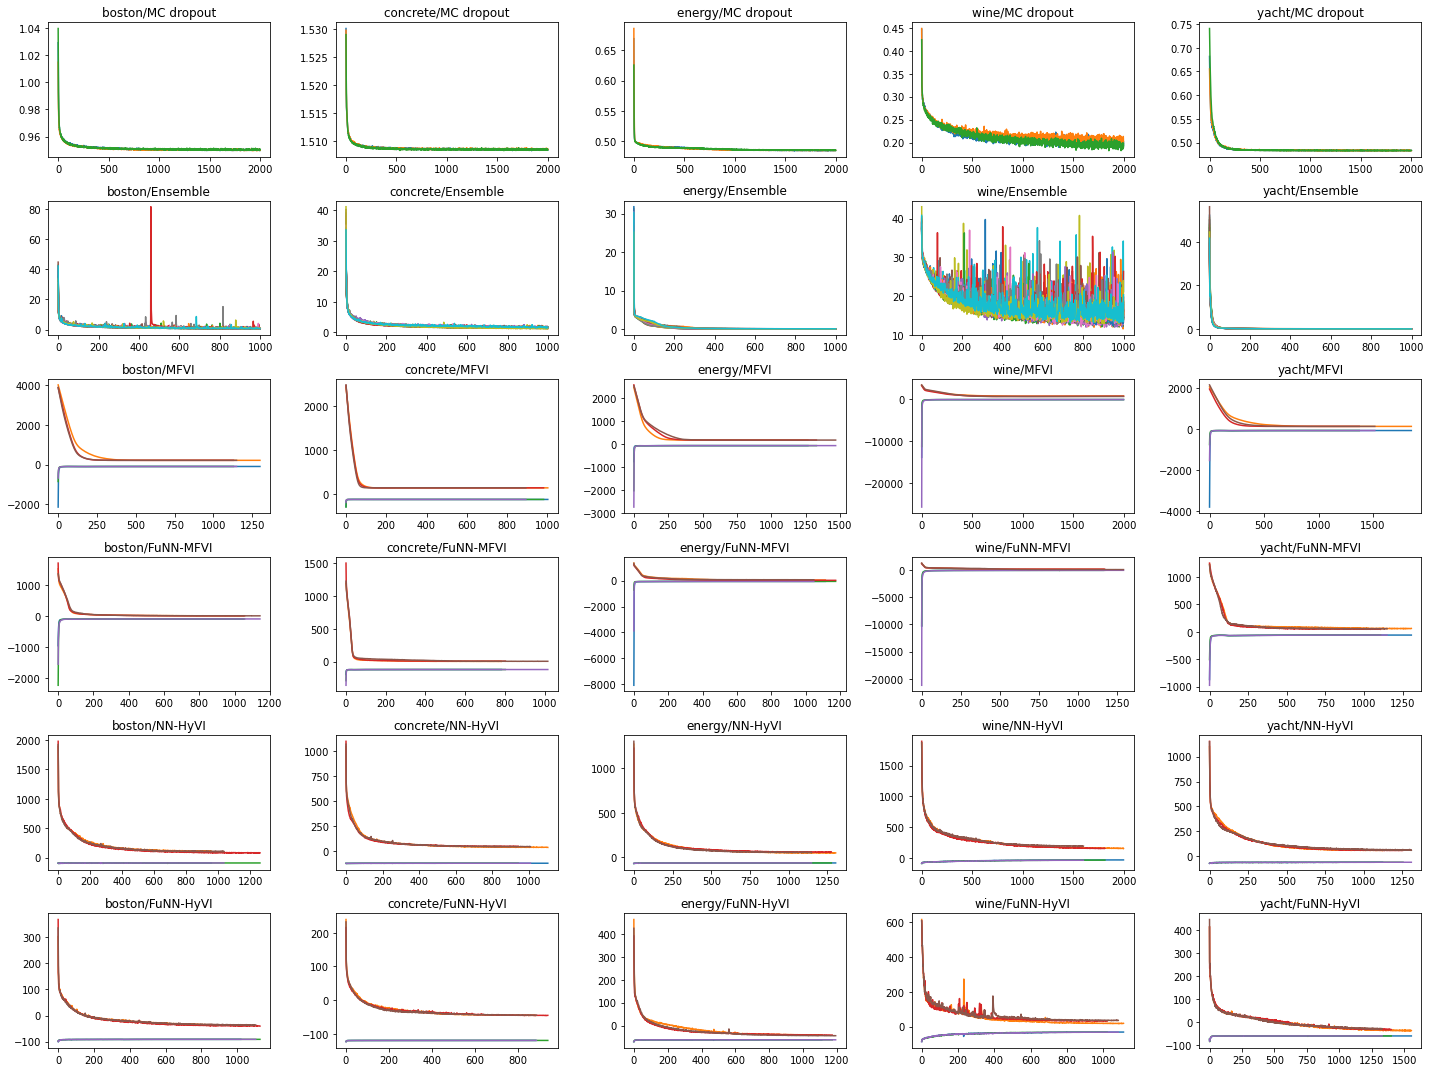

In [22]:
from pylab import *
fig, ax=plt.subplots(len(methods)-1, len(datasets), figsize=(20,15))
ax=ax.flatten()
i=0

for method in ['MC dropout','Ensemble','MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI']:
    for dataset in datasets:
        for split in MODELS[dataset]: 
            logs=split[1][method][1]
            for key in logs.keys():
                if key=='KL' or key=='loss' or key=='LL' or isinstance(key, int): 
                    ax[i].plot(range(len(logs[key])), logs[key])#, label=key)
                #ax[i].legend()
                ax[i].set_title(dataset+'/'+method)
        i+=1

fig.tight_layout()

# OOD detection

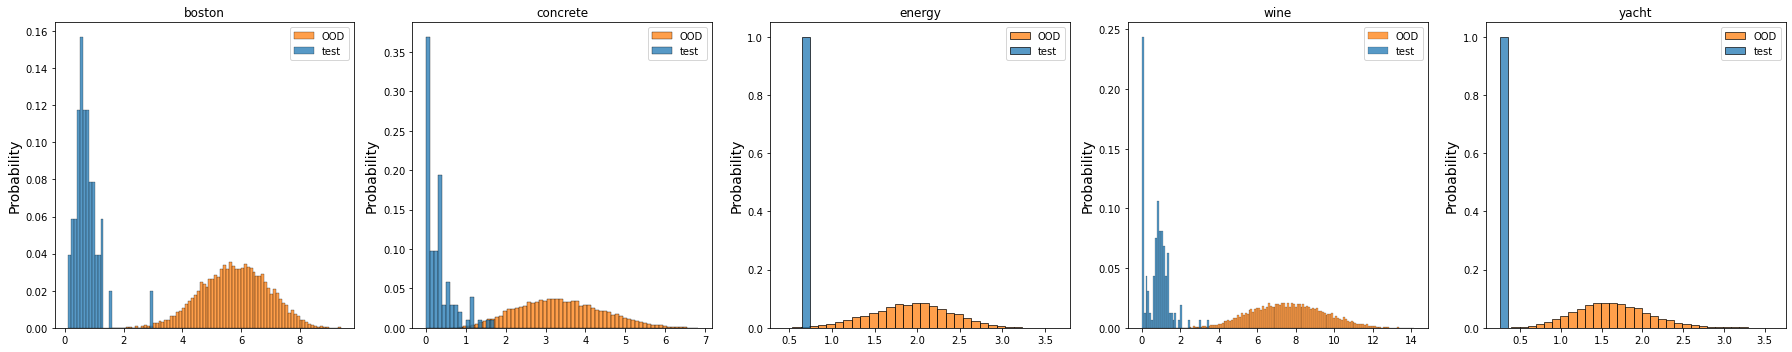

In [23]:
import seaborn as sns
from pylab import *
from torch.distributions import MultivariateNormal
from matplotlib.colors import ListedColormap

cmap=ListedColormap(sns.color_palette("tab10").as_hex())


def nn_dist(X):
    #X_in=torch.cat([X[0],X[1]])
    X_train=X[0]
    X_test=X[1]
    X_ood=X[2]
    dist_ood=torch.cdist(X_train,X_ood)
    dist_test=torch.cdist(X_train,X_test)
    #print(X_in.shape, X_ood.shape, dist.shape)
    return dist_test.min(dim=0)[0], dist_ood.min(dim=0)[0]

fig, ax=plt.subplots(1,5, figsize=(25,5))
ax=ax.flatten()
i=0
for dataset in datasets:
    split_nb=0
    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=10000) #MultivariateNormal(x_train.mean(0), covariance_matrix=.5*torch.diag(x_train.std(0))) #
        x_OOD=OOD_sampler()#OOD_sampler.sample((50000,))
        
        X = [x_train, x_test, x_OOD]
        if split_nb==2:
            test, ood= nn_dist(X)
            sns.histplot(ood.cpu(), stat='probability', binwidth=0.1,ax=ax[i], label='OOD', color=cmap(1))
            ax[i].set_title(dataset)
#             if test.std() < 0.01:
#                 ax[i].vlines(x=test.mean(), ymin=0, ymax=1, color=cmap(1), label='test')
#             else:
            sns.histplot(test.cpu(), stat='probability', binwidth=0.1, ax=ax[i], label='test', color=cmap(0))
            ax[i].legend()
            i+=1
fig.tight_layout()

In [8]:
import seaborn as sns
from pylab import *
import math
from Tools import uniform_rect_sampler
from Metrics import batch_entropy_nne

VARs={dataset:{method: [] for method in methods} for dataset in datasets}
#Hs=torch.load(path+'_epist_entropy_50k.pt')
#MODELS.to(device)
def VAR(model, X):
#    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]
    return [torch.cat([model(x_, 1000).detach().std(0).squeeze() for x_ in x.split(500,dim=0)],dim=0) for x in X]


n_ood=10000
for dataset in datasets:
    print(dataset)
    split_nb=0
    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        print(split_nb)
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=n_ood) #MultivariateNormal(x_train.mean(0), covariance_matrix=.5*torch.diag(x_train.std(0))) #
        x_OOD=OOD_sampler() #OOD_sampler.sample((n_ood,))#
        
        X = [x_train, x_test, x_OOD]
        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=10).to(device)
        model.load_state_dict(split[1][method][0])
        Y = [model(x) for x in X]
        VARs[dataset][method].append([y.std(0).squeeze() for y in Y])

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        Y=[torch.cat([model.predict(x_, 1000).detach() for x_ in x.split(500,dim=0)],dim=1) for x in X]
        #Y=[model.predict(x, 1000) for x in X]
        VARs[dataset][method].append([y.std(0).squeeze() for y in Y])
         
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))

        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))
        
        predictor=model.predictor
        method='HMC'
        HMC_=models_HMC[dataset]
        indices = torch.randperm(len(HMC_))[:1000]
        theta=HMC_[indices].to(device)
        VARs[dataset][method].append([torch.cat([predictor(x_, theta).detach().std(0).squeeze() for x_ in x.split(500,dim=0)],dim=0) for x in X])
        
        torch.save(VARs,path+'_epist_VAR_10k.pt')

boston
0
1
2
concrete
0
1
2
energy
0
1
2
wine
0
1
2
yacht
0
1
2


In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
from pylab import *
import numpy as np
cmap=plt.get_cmap('Set1')
Hs=torch.load(path+'_epist_VAR_10k.pt')
roc_data={dataset:{} for dataset in datasets}
AUC={}#{dataset:{} for dataset in datsets}

fpr=torch.arange(n_ood).true_divide(n_ood)

for dataset in datasets:     
    for method in methods:
        AUCs=[]

        TPRs=[]
        for h in Hs[dataset][method]:
            H_in=torch.cat([h[0],h[1]]).cpu()
            H_ood, _=h[2].cpu().sort()
            TPRs.append((H_in.unsqueeze(-1) < H_ood).sum(0).true_divide(len(H_in)))

            y_true=torch.cat([torch.ones_like(torch.cat([h[0],h[1]])),torch.zeros_like(h[2])])
            y_score=-torch.cat([h[0],h[1],h[2]])
            AUCs.append(roc_auc_score(y_true.cpu(), y_score.cpu()))
        roc_data[dataset].update({method: {'AUC':np.mean(AUCs),'tpr_mean': torch.stack(TPRs).mean(0), 'tpr_min':torch.stack(TPRs).min(0)[0], 'tpr_max':torch.stack(TPRs).max(0)[0]}})

        print(dataset+"/"+method+": {}".format(np.mean(AUCs)))

boston/MC dropout: 0.9480016469038208
boston/Ensemble: 0.9999945981554678
boston/MFVI: 0.9700218708827405
boston/FuNN-MFVI: 0.9965710803689065
boston/NN-HyVI: 0.9953233860342555
boston/FuNN-HyVI: 0.9999584980237154
boston/HMC: 0.9999642951251646
concrete/MC dropout: 0.9254561812297734
concrete/Ensemble: 0.9997651132686084
concrete/MFVI: 0.9341390291262135
concrete/FuNN-MFVI: 0.9882682847896441
concrete/NN-HyVI: 0.9922266990291263
concrete/FuNN-HyVI: 0.9974581553398059
concrete/HMC: 0.995435501618123
energy/MC dropout: 0.7501952907986111
energy/Ensemble: 1.0
energy/MFVI: 0.4121305121527778
energy/FuNN-MFVI: 0.969707421875
energy/NN-HyVI: 0.9998789062499999
energy/FuNN-HyVI: 0.9999915364583333
energy/HMC: 0.999660373263889
wine/MC dropout: 0.987645299145299
wine/Ensemble: 0.9997157806962683
wine/MFVI: 0.9963514488221805
wine/FuNN-MFVI: 0.9959174588284344
wine/NN-HyVI: 0.9996292474463205
wine/FuNN-HyVI: 0.9996898895142797
wine/HMC: 0.9999989159891598
yacht/MC dropout: 0.48211266233766237


In [16]:
torch.save(roc_data,path+'_roc_data.pt')

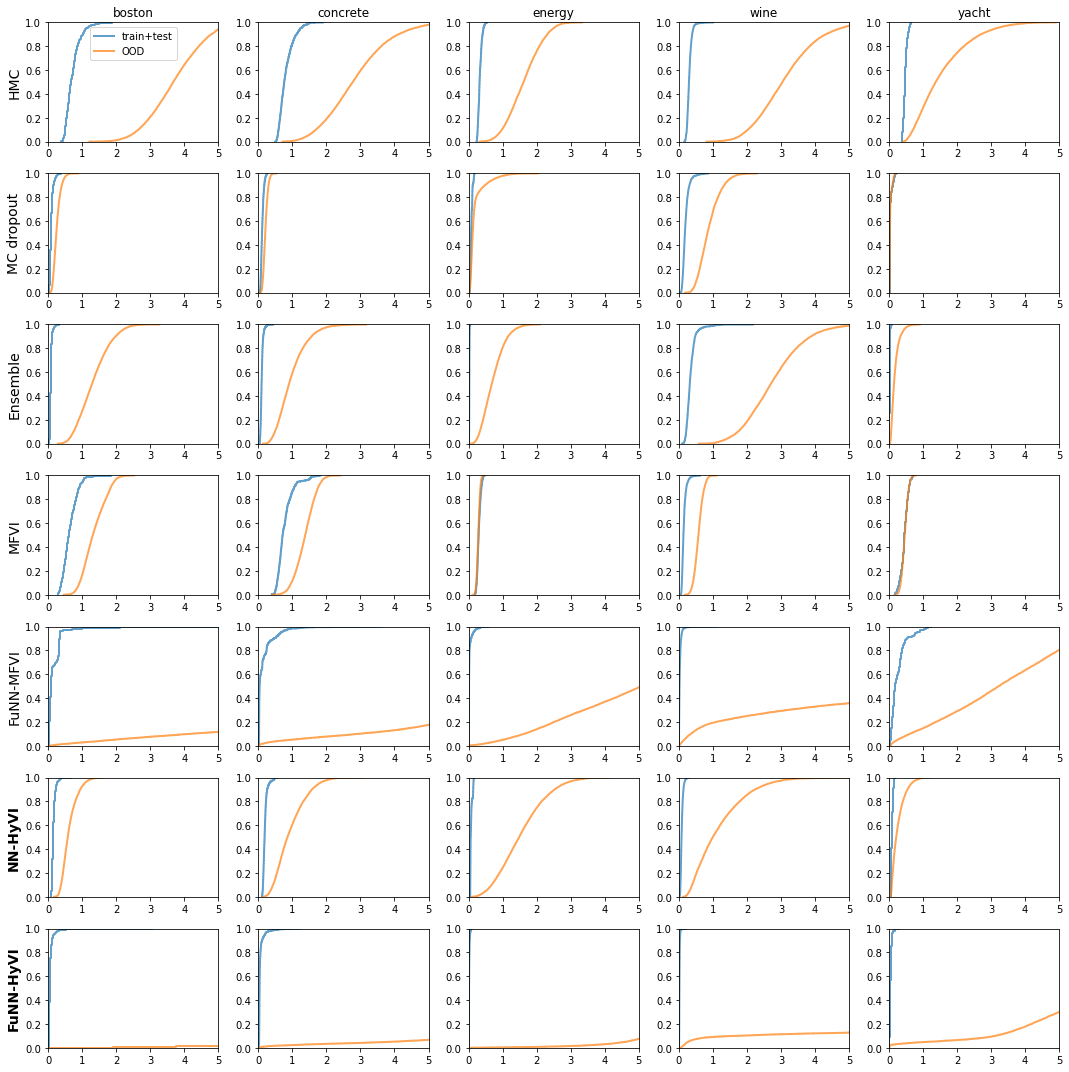

In [11]:
from pylab import *
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap


parameters = {'axes.labelsize':14,
              'axes.titlesize': 12,
              'xtick.labelsize' : 10,
              'ytick.labelsize' : 10,
              'figure.titlesize':14}
plt.rcParams.update(parameters)
Hs=torch.load(path+'_epist_VAR_10k.pt')
n_datasets=len(datasets)
n_methods=len(methods)
fig,ax=plt.subplots(n_methods,n_datasets,figsize=(15,15),squeeze=False)

data_type=['train+test', 'OOD']
method_names=['MC dropout','Ensemble','MFVI','FuNN-MFVI','NN-HyVI','FuNN-HyVI']

split=1
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
d=0
for dataset in datasets:
    m=0
    ax[m,d].set_title(dataset)
    for method in methods:
        H_=Hs[dataset][method][split]
        H=[torch.cat([H_[0],H_[1]]), H_[2]]
        #for i in range(len(H)):
        #data=pd.DataFrame([pd.DataFrame(H[i].cpu(), columns=[data_type[i]]) for i in range(3)], columns=['type'])
        #print(data)
        #print(data)
 #       data=pd.concat([pd.Series(H[0].cpu(),name='train'),pd.Series(H[1].cpu(),name='test'),pd.Series(H[2].cpu(),name='OOD')], axis=0, join='inner')
#        print(data)
        for i in range(len(H)):
            #sns.histplot(H[i].cpu(), stat='density', element='step', alpha = .7, kde=True, color=cmap(i), label=data_type[i],ax=ax[m,d])#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],
            sns.ecdfplot(H[i].cpu(),color=cmap(i), label=data_type[i],ax=ax[m,d],lw=2, alpha=.7)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],

        if (m,d) == (0,0): 
            ax[m,d].legend()#.remove()
        ax[m,d].set_xlim(left=0, right=5)
        ax[m,d].set_ylabel('')
        if d ==0:
            if method=='FuNN-HyVI' or method== 'NN-HyVI' or method== 'FuNN-HyVI*':
                ax[m,d].set_ylabel(method, {'fontweight':'bold'})
            else:
                ax[m,d].set_ylabel(method)
        m+=1

    d+=1
#ax[3,2].legend(loc='upper right', prop={'size': 8})#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()
fig.align_ylabels(ax[:, 0])
plt.savefig(path+"_EpistVarECDF_Exp2-{}.pdf".format(split), dpi=600)
#plt.subplots_adjust(top=.9)
#plt.suptitle('Posterior Predictive Entropy Distributions')
plt.show()

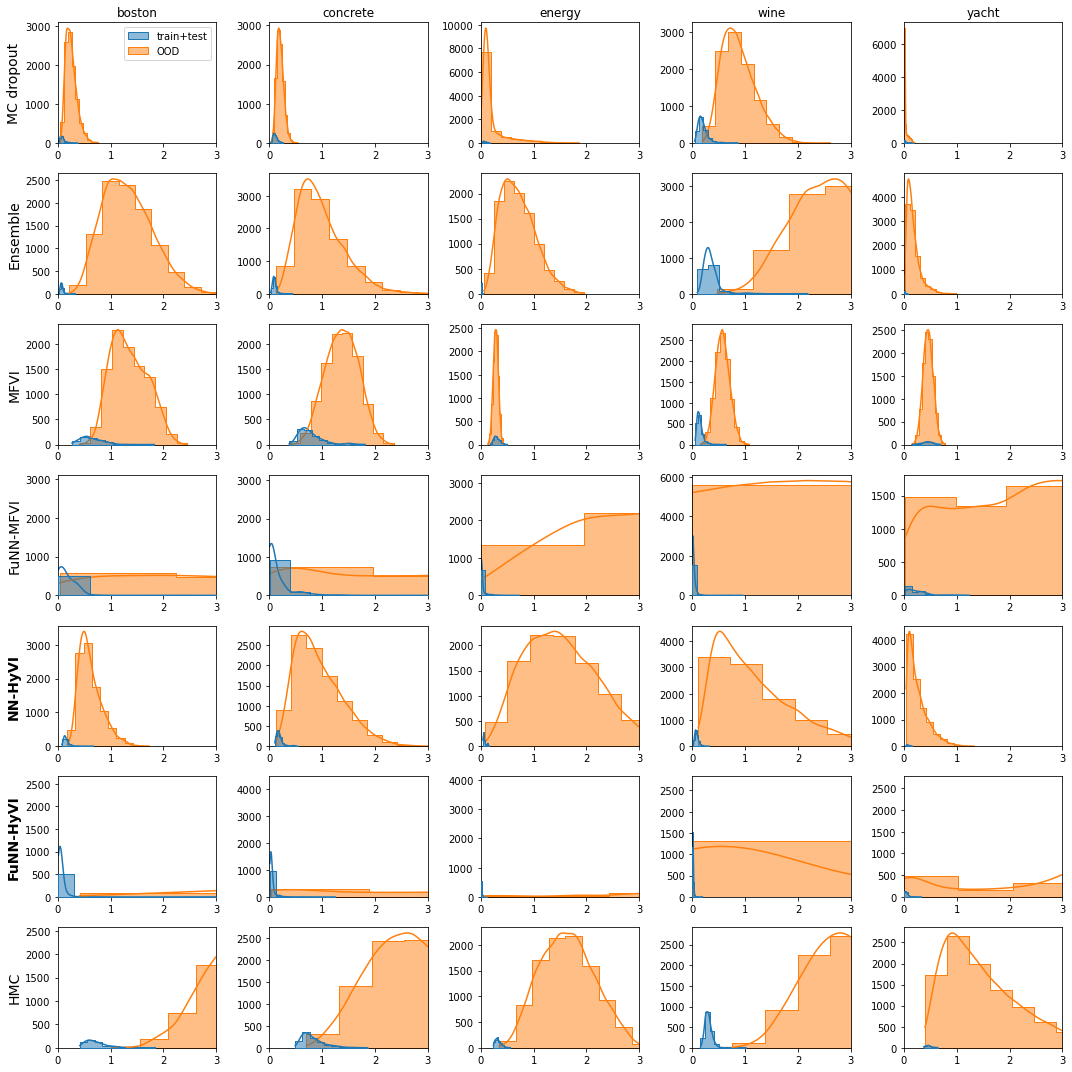

In [59]:
from pylab import *
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap

parameters = {'axes.labelsize':14,
              'axes.titlesize': 12,
              'xtick.labelsize' : 10,
              'ytick.labelsize' : 10,
              'figure.titlesize':14}
plt.rcParams.update(parameters)
Hs=VARs
n_datasets=len(datasets)
n_methods=len(methods)
fig,ax=plt.subplots(n_methods,n_datasets,figsize=(15,15),squeeze=False)

data_type=['train+test', 'OOD']
method_names=['MC dropout','Ensemble','MFVI','FuNN-MFVI','NN-HyVI','FuNN-HyVI']

split=1
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
d=0
for dataset in datasets:
    m=0
    max_var=[]
    ax[m,d].set_title(dataset)
    for method in methods:
        H_=Hs[dataset][method][split]
        H=[torch.cat([H_[0],H_[1]]), H_[2]]

        #for i in range(len(H)):
        #data=pd.DataFrame([pd.DataFrame(H[i].cpu(), columns=[data_type[i]]) for i in range(3)], columns=['type'])
        #print(data)
        #print(data)
 #       data=pd.concat([pd.Series(H[0].cpu(),name='train'),pd.Series(H[1].cpu(),name='test'),pd.Series(H[2].cpu(),name='OOD')], axis=0, join='inner')
#        print(data)
        for i in range(len(H)):
            max_var.append(H[i].max().cpu())
            sns.histplot(H[i].cpu(), stat='count', bins=10, element='step', alpha = .5, kde=True, color=cmap(i), label=data_type[i],ax=ax[m,d], zorder=3-i)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],
            #sns.ecdfplot(H[i].cpu(),color=cmap(i), label=data_type[i],ax=ax[m,d],lw=2, alpha=.7)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],

        if (m,d) == (0,0): 
            ax[m,d].legend()#.remove()
        ax[m,d].set_ylabel('')
        if d ==0:
            if method=='FuNN-HyVI' or method== 'NN-HyVI' or method== 'FuNN-HyVI*':
                ax[m,d].set_ylabel(method, {'fontweight':'bold'})
            else:
                ax[m,d].set_ylabel(method)
        m+=1
    for m in range(n_methods):
        ax[m,d].set_xlim(left=0., right=3)#np.max(max_var))

    d+=1
#ax[3,2].legend(loc='upper right', prop={'size': 8})#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()
fig.align_ylabels(ax[:, 0])
plt.savefig(path+"_EpistVarDist_Exp2-{}.pdf".format(split), dpi=600)
#plt.subplots_adjust(top=.9)
#plt.suptitle('Posterior Predictive Entropy Distributions')
plt.show()

HMC
MC dropout
Ensemble
MFVI
FuNN-MFVI
NN-HyVI
FuNN-HyVI


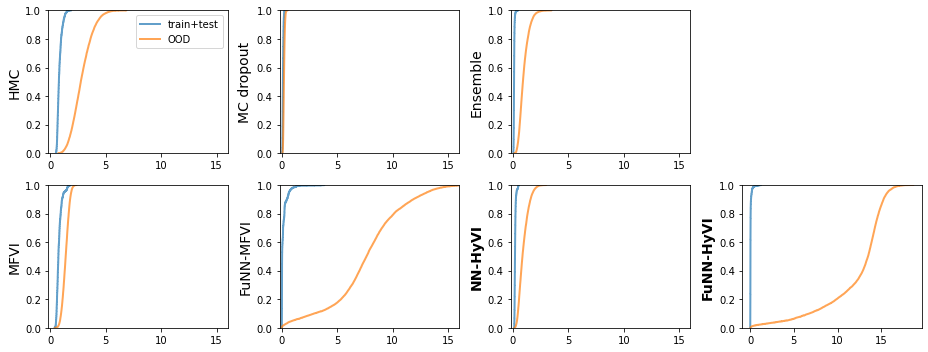

In [17]:
from pylab import *
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap

parameters = {'axes.labelsize':14,
              'axes.titlesize': 12,
              'xtick.labelsize' : 10,
              'ytick.labelsize' : 10,
              'figure.titlesize':14}
plt.rcParams.update(parameters)
Hs=torch.load(path+'_epist_VAR_10k.pt')

n_methods=len(methods)
fig,ax=plt.subplots(2,4,figsize=(13,5),squeeze=True)
ax=ax.flatten()
data_type=['train+test', 'OOD']
method_names=['MC dropout','Ensemble','MFVI','FuNN-MFVI','NN-HyVI','FuNN-HyVI']

split=1
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
d=0
for dataset in ['concrete']:
    m=0
    max_var=[]
    #ax.set_title(dataset)
    for method in methods:
        H_=Hs[dataset][method][split]
        H=[torch.cat([H_[0],H_[1]]), H_[2]]
        #for i in range(len(H)):
        #data=pd.DataFrame([pd.DataFrame(H[i].cpu(), columns=[data_type[i]]) for i in range(3)], columns=['type'])
        #print(data)
        #print(data)
 #       data=pd.concat([pd.Series(H[0].cpu(),name='train'),pd.Series(H[1].cpu(),name='test'),pd.Series(H[2].cpu(),name='OOD')], axis=0, join='inner')
#        print(data)
        print(method)
        
        for i in range(len(H)):
            max_var.append(H[i].max().cpu())
            #sns.histplot(H[i].cpu(), stat='density', bins=10, element='step', alpha = .5, kde=True, color=cmap(i), label=data_type[i],ax=ax[m], zorder=3-i)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],
            sns.ecdfplot(H[i].pow(1).cpu(),color=cmap(i), label=data_type[i],ax=ax[m],lw=2, alpha=.7)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],

        if m==0: 
            ax[m].legend()#.remove()
        ax[m].set_ylabel('')
        if d ==0:
            if method=='FuNN-HyVI' or method== 'NN-HyVI' or method== 'FuNN-HyVI*':
                ax[m].set_ylabel(method, {'fontweight':'bold'})
            else:
                ax[m].set_ylabel(method)
        m+=1
        if m==3:
            m+=1
    for m in range(n_methods):
        ax[m].set_xlim(left=-.2, right=16)
        #ax[m].set_ylim(bottom=0., top=1.1)


    d+=1
ax[3].remove()    
#ax[3,2].legend(loc='upper right', prop={'size': 8})#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()
#fig.align_ylabels(ax[:, 0])
plt.savefig(path+"_EpistVarECDF_Exp2-{}.pdf".format(dataset), dpi=600)
#plt.subplots_adjust(top=.9)
#plt.suptitle('Posterior Predictive Entropy Distributions')
plt.show()

<ipython-input-109-d56d4607a670>:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


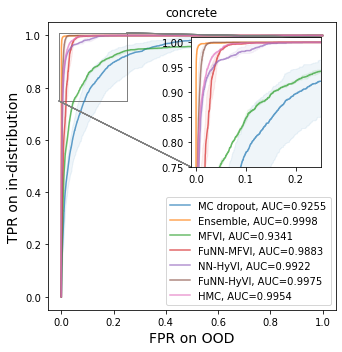

In [109]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset
from matplotlib.colors import ListedColormap

from pylab import *
import seaborn as sns
l=1
fig, ax= plt.subplots(1,l,figsize=(5,5))

roc_data=torch.load(path+'_roc_data.pt')
dataset='concrete'
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
R=[0.25]
B=[ 0.75]
ax=[ax]
def add_zero(x):
    return torch.cat([torch.zeros(1,1),x.view(-1,1)]).squeeze()
n_ood=10000
fpr=add_zero(torch.arange(n_ood).true_divide(n_ood))
d=0
for dataset in [dataset]:
    c=0

    zoom_ax = inset_axes(ax[d], width=1.8, height=1.8,  loc='upper right',borderpad=1.5)      
    for method in ['MC dropout','Ensemble','MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI','HMC']:
        AUC=roc_data[dataset][method]['AUC']
        tpr_mean=add_zero(roc_data[dataset][method]['tpr_mean'])
        tpr_min=add_zero(roc_data[dataset][method]['tpr_min'])
        tpr_max=add_zero(roc_data[dataset][method]['tpr_max'])
        ax[d].plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
        ax[d].fill_between(fpr, tpr_min, tpr_max, alpha=0.07, color=cmap(c))

        zoom_ax.plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
        zoom_ax.fill_between(fpr, tpr_min, tpr_max, alpha=0.07, color=cmap(c))  
        mark_inset(ax[d], zoom_ax, loc1=1, loc2=3, fc="none", ec="0.5")

        c+=1
    zoom_ax.set_xlim(left=-0.01, right=R[d])
    zoom_ax.set_ylim(bottom=B[d], top=1.01)
    zoom_ax.legend().remove()
    zoom_ax.set_xlabel('')
    zoom_ax.set_ylabel('')
    zoom_ax.set_aspect('equal')
    ax[d].legend(prop={'size':10})
    ax[d].set_title(dataset)
    ax[d].set_xlabel('FPR on OOD')
    ax[d].set_ylabel('TPR on in-distribution')
    ax[d].set_xlim(left=-0.05, right=1.05)
    ax[d].set_ylim(bottom=-.05, top=1.05)
    ax[d].set_aspect('equal')

    d+=1


fig.tight_layout()
plt.savefig(path+"_ROC_curves_{}.pdf".format(dataset), dpi=600)


<ipython-input-152-fb7e72bbb2c0>:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


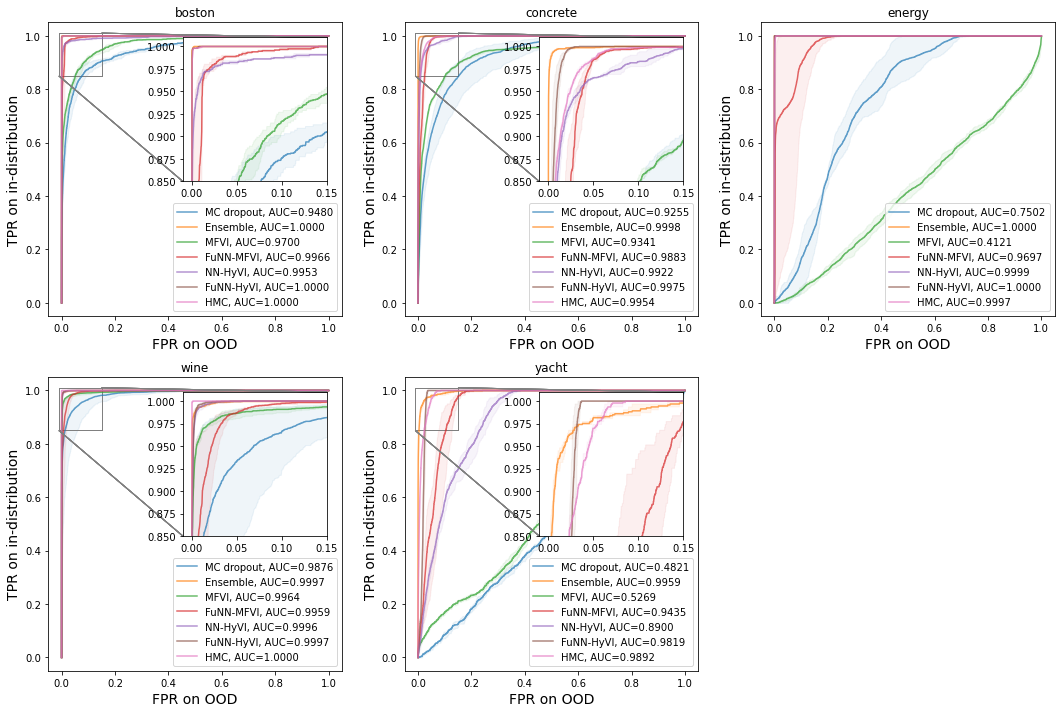

In [152]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset
from matplotlib.colors import ListedColormap

from pylab import *
import seaborn as sns
l=len(datasets)
fig, ax= plt.subplots(2,3,figsize=(5*3,10))
ax=ax.flatten()
d=0
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
R=[0.15 for _ in range(6)]
B=[0.85 for _ in range(6)]

methods=['MC dropout','Ensemble','MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI', 'HMC']

def add_zero(x):
    return torch.cat([torch.zeros(1,1),x.view(-1,1)]).squeeze()
fpr=add_zero(torch.arange(n_ood).true_divide(n_ood))
colors=[]
for dataset in datasets:
    c=0
    if not dataset == 'energy': 
        zoom_ax = inset_axes(ax[d], width=2, height=2,  loc='upper right', borderpad=1.5)      
    for method in methods:
        AUC=roc_data[dataset][method]['AUC']
        tpr_mean=add_zero(roc_data[dataset][method]['tpr_mean'])
        tpr_min=add_zero(roc_data[dataset][method]['tpr_min'])
        tpr_max=add_zero(roc_data[dataset][method]['tpr_max'])
        ax[d].plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
        ax[d].fill_between(fpr, tpr_min, tpr_max, alpha=0.07, color=cmap(c))
        if not dataset == 'energy': 
            zoom_ax.plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
            zoom_ax.fill_between(fpr, tpr_min, tpr_max, alpha=0.07, color=cmap(c))  
            mark_inset(ax[d], zoom_ax, loc1=1, loc2=3, fc="none", ec="0.5")

        c+=1
    zoom_ax.set_xlim(left=-0.01, right=R[d])
    zoom_ax.set_ylim(bottom=B[d], top=1.01)
    zoom_ax.legend().remove()
    zoom_ax.set_xlabel('')
    zoom_ax.set_ylabel('')
    zoom_ax.set_aspect('equal')
    ax[d].legend()
    ax[d].set_title(dataset)
    ax[d].set_xlabel('FPR on OOD')
    ax[d].set_ylabel('TPR on in-distribution')
    ax[d].set_xlim(left=-0.05, right=1.05)
    ax[d].set_ylim(bottom=-.05, top=1.05)
    ax[d].set_aspect('equal')

    d+=1

ax[5].remove()
fig.tight_layout()
plt.savefig(path+"ROC_curves_VAR_MinMax_square.pdf", dpi=600)


<Figure size 432x288 with 0 Axes>

# Parametric vs Predictor Entropy

In [68]:
from Metrics import entropy_nne
def FunH(model, sampler, n=100, n_MC=200):
    Hs=[entropy_nne(model(sampler()).squeeze(2), k=1, k_MC=n_MC).item() for _ in range(n)]
    return np.mean(Hs)



In [71]:
import seaborn as sns
from pylab import *
import math
from Tools import uniform_rect_sampler
from Metrics import batch_entropy_nne

Hs={dataset:{} for dataset in datasets}

def Entropy(model, X):
    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]

def univariate_gaussian_entropy(sigma=None, var=None):
    if sigma is not None:
        return 0.5*torch.log(2*math.pi*math.e*sigma**2)
    if var is not None:
        return 0.5*torch.log(2*math.pi*math.e*var)

nb_predictors=1000    
n_MC=200
    
for dataset in datasets:
    print(dataset)
    split_nb=0
    Hs[dataset].update({(method,'parameter'):[] for method in methods})
    Hs[dataset].update({(method,'predictor'):[] for method in methods})

    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        print(split_nb)
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=n_MC)
        x_OOD=OOD_sampler()
        
        X = [x_train, x_test, x_OOD]
        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=10).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.get_parameters, k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(model, OOD_sampler, n=100, n_MC=200))

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model.predict(x,nb_predictors), OOD_sampler, n=100, n_MC=200))
         
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))

        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))
        
        predictor=model.predictor
        method='HMC'
        HMC_=models_HMC[dataset]
        indices = torch.randperm(len(HMC_))[:1000]
        theta=HMC_[indices].to(device)
        Hs[dataset][(method,'parameter')].append(entropy_nne(theta, k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: predictor(x,theta), OOD_sampler, n=100, n_MC=200))
   

boston
0
1
2
concrete
0
1
2
energy
0
1
2
wine
0
1
2
yacht
0
1
2


In [72]:
torch.save(Hs,path+'_ParamVsPredictor_entropy.pt')
Hs=torch.load(path+'_ParamVsPredictor_entropy.pt')


In [73]:
import pandas as pd

H_mean={} 
H_std={}
for dataset, value in Hs.items():
    #print(dataset)
    H_mean.update({dataset:{}})
    H_std.update({dataset:{}})
    for key2, results in value.items():
        #print(key2)
        H_mean[dataset].update({key2:np.mean(results)})
        H_std[dataset].update({key2:np.std(results)})

/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [78]:
methods=['HMC','MC dropout', 'Ensemble', 'MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI']
index=pd.MultiIndex.from_product([methods,["parameter"]])
df=pd.DataFrame(H_mean, index=index).transpose()
df_=pd.DataFrame(H_std, index=index).transpose()
df.style.background_gradient(axis=1,cmap='viridis')

,HMC,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
,parameter,parameter,parameter,parameter,parameter,parameter,parameter
boston,970.108724,nan,332.002848,566.851644,-1117.032349,1555.222331,350.224487
concrete,635.040548,nan,424.367147,352.957255,-697.193278,1077.710042,430.903829
energy,628.108297,nan,193.422119,347.548075,-464.894450,1098.067139,334.377421
wine,615.452677,nan,811.732300,246.586466,-1035.009135,1455.032104,-1596.111165
yacht,502.244995,nan,151.926107,262.828145,-589.057841,772.424113,145.399231


In [79]:
for i in df.columns:
    df[i] = df[i].round().astype(str)+ "±" + (df_[i].round()).astype(str)+""

print(df.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &        HMC & MC dropout &   Ensemble &        MFVI &      FuNN-MFVI &      NN-HyVI &      FuNN-HyVI \\
{} &  parameter &  parameter &  parameter &   parameter &      parameter &    parameter &      parameter \\
\midrule
boston   &  970.0±1.0 &    nan±nan &  332.0±5.0 &   567.0±1.0 &  -1117.0±289.0 &  1555.0±25.0 &     350.0±27.0 \\
concrete &  635.0±1.0 &    nan±nan &  424.0±2.0 &   353.0±1.0 &    -697.0±60.0 &   1078.0±2.0 &      431.0±9.0 \\
energy   &  628.0±1.0 &    nan±nan &  193.0±4.0 &   348.0±1.0 &   -465.0±126.0 &  1098.0±12.0 &     334.0±52.0 \\
wine     &  615.0±4.0 &    nan±nan &  812.0±6.0 &  247.0±30.0 &  -1035.0±183.0 &  1455.0±59.0 &  -1596.0±165.0 \\
yacht    &  502.0±0.0 &    nan±nan &  152.0±4.0 &   263.0±0.0 &    -589.0±85.0 &    772.0±8.0 &     145.0±78.0 \\
\bottomrule
\end{tabular}



In [75]:
pd.DataFrame(H_std, index=index).transpose()

,HMC,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
,parameter,parameter,parameter,parameter,parameter
boston,0.602752,0.633811,288.669968,25.081466,26.674711
concrete,0.894029,0.516104,60.342040,2.092121,8.866241
energy,0.568170,0.942266,125.600680,11.752374,51.842641
wine,3.948261,30.045836,182.833136,58.778888,165.278841
yacht,0.441265,0.286105,85.036515,7.810557,77.900796


In [80]:
index=pd.MultiIndex.from_product([methods,["predictor"]])
df=pd.DataFrame(H_mean, index=index).transpose()
df_=pd.DataFrame(H_std, index=index).transpose()
df.style.background_gradient(axis=1,cmap='viridis')

,HMC,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
,predictor,predictor,predictor,predictor,predictor,predictor,predictor
boston,-51.517286,-490.717891,-171.050399,-317.047819,121.823147,-397.967604,294.300159
concrete,-107.035441,-492.407178,-211.252201,-316.219034,76.009198,-423.465429,273.139522
energy,-223.809253,-506.121848,-346.418356,-586.752973,-9.938979,-300.946345,160.143221
wine,-24.508978,-234.488006,6.568569,-421.717926,128.357885,-284.937044,254.142665
yacht,-243.532622,-843.820315,-573.863112,-492.133163,-82.936571,-667.087234,113.355737


In [81]:
pd.DataFrame(H_std, index=index).transpose()

,HMC,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
,predictor,predictor,predictor,predictor,predictor,predictor,predictor
boston,0.735350,6.748793,5.805441,0.118338,2.732735,6.154556,10.275546
concrete,0.666586,18.551588,15.691931,0.031056,2.276696,6.918037,1.675213
energy,1.528436,66.578077,13.064150,0.458444,17.312080,20.487009,10.474790
wine,0.605491,32.841128,2.998226,9.750595,33.617214,23.654009,22.708464
yacht,0.657389,6.668331,8.220359,0.213073,10.131800,6.893335,15.379467


In [82]:
for i in df.columns:
    df[i] = df[i].round().astype(str)+ "±" + (df_[i].round()).astype(str)+""

print(df.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &         HMC &   MC dropout &     Ensemble &         MFVI &   FuNN-MFVI &      NN-HyVI &   FuNN-HyVI \\
{} &   predictor &    predictor &    predictor &    predictor &   predictor &    predictor &   predictor \\
\midrule
boston   &   -52.0±1.0 &   -491.0±7.0 &   -171.0±6.0 &   -317.0±0.0 &   122.0±3.0 &   -398.0±6.0 &  294.0±10.0 \\
concrete &  -107.0±1.0 &  -492.0±19.0 &  -211.0±16.0 &   -316.0±0.0 &    76.0±2.0 &   -423.0±7.0 &   273.0±2.0 \\
energy   &  -224.0±2.0 &  -506.0±67.0 &  -346.0±13.0 &   -587.0±0.0 &  -10.0±17.0 &  -301.0±20.0 &  160.0±10.0 \\
wine     &   -25.0±1.0 &  -234.0±33.0 &      7.0±3.0 &  -422.0±10.0 &  128.0±34.0 &  -285.0±24.0 &  254.0±23.0 \\
yacht    &  -244.0±1.0 &   -844.0±7.0 &   -574.0±8.0 &   -492.0±0.0 &  -83.0±10.0 &   -667.0±7.0 &  113.0±15.0 \\
\bottomrule
\end{tabular}



# VAR vs Entropy


In [20]:
def Entropy(model, X):
    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]


def univariate_gaussian_entropy(sigma=None, var=None):
    if sigma is not None:
        return 0.5*torch.log(2*math.pi*math.e*sigma**2)
    if var is not None:
        return 0.5*torch.log(2*math.pi*math.e*var)
    


import seaborn as sns
from pylab import *
import math
from Tools import uniform_rect_sampler
from Metrics import batch_entropy_nne

ENTs={dataset:{method: [] for method in methods} for dataset in datasets}
#Hs=torch.load(path+'_epist_entropy_50k.pt')
#MODELS.to(device)
def VAR(model, X):
#    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]
    return [torch.cat([model(x_, 1000).detach().std(0).squeeze() for x_ in x.split(500,dim=0)],dim=0) for x in X]


n_ood=10000
for dataset in datasets:
    print(dataset)
    split_nb=0
    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        print(split_nb)
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=n_ood) #MultivariateNormal(x_train.mean(0), covariance_matrix=.5*torch.diag(x_train.std(0))) #
        x_OOD=OOD_sampler() #OOD_sampler.sample((n_ood,))#
        
        X = [x_train, x_test, x_OOD]
        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=10).to(device)
        model.load_state_dict(split[1][method][0])
        Y = [model(x) for x in X]
        ENTs[dataset][method].append([univariate_gaussian_entropy(sigma=y.std(0).squeeze()) for y in Y])

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        Y=[torch.cat([model.predict(x_, 1000).detach() for x_ in x.split(500,dim=0)],dim=1) for x in X]
        #Y=[model.predict(x, 1000) for x in X]
        ENTs[dataset][method].append([univariate_gaussian_entropy(sigma=y.std(0).squeeze()) for y in Y])
         
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        ENTs[dataset][method].append(Entropy(model,X))
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        ENTs[dataset][method].append(Entropy(model,X))

        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        ENTs[dataset][method].append(Entropy(model,X))
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        ENTs[dataset][method].append(Entropy(model,X))
        
        predictor=model.predictor
        method='HMC'
        HMC_=models_HMC[dataset]
        indices = torch.randperm(len(HMC_))[:1000]
        theta=HMC_[indices].to(device)
        ENTs[dataset][method].append([torch.cat([univariate_gaussian_entropy(predictor(x_, theta).detach().std(0).squeeze()) for x_ in x.split(500,dim=0)],dim=0) for x in X])
        
        torch.save(ENTs,path+'_epist_H_10k.pt')

from sklearn.metrics import roc_curve, roc_auc_score
from pylab import *
import numpy as np
cmap=plt.get_cmap('Set1')
Hs=torch.load(path+'_epist_VAR_10k.pt')
roc_data={dataset:{} for dataset in datasets}
AUC={}#{dataset:{} for dataset in datsets}


n_ood=10000
fpr=torch.arange(n_ood).true_divide(n_ood)

for dataset in datasets:     
    for method in methods:
        AUCs=[]

        TPRs=[]
        for h in Hs[dataset][method]:
            H_in=h[1].cpu()#torch.cat([h[0],h[1]]).cpu()
            H_ood, _=h[2].cpu().sort()
            TPRs.append((H_in.unsqueeze(-1) < H_ood).sum(0).true_divide(len(H_in)))

            y_true=torch.cat([torch.ones_like(torch.cat([h[0],h[1]])),torch.zeros_like(h[2])])
            y_score=-torch.cat([h[0],h[1],h[2]])
            AUCs.append(roc_auc_score(y_true.cpu(), y_score.cpu()))
        roc_data[dataset].update({method: {'AUC':np.mean(AUCs),'tpr_mean': torch.stack(TPRs).mean(0), 'tpr_min':torch.stack(TPRs).min(0)[0], 'tpr_max':torch.stack(TPRs).max(0)[0]}})

        print(dataset+"/"+method+": {}".format(np.mean(AUCs)))
torch.save(roc_data, path+'_AUC_VAR10k.pt')



In [146]:
AUC_VAR=torch.load(path+'_AUC_VAR10k.pt')
AUC=torch.load(path+'_AUC_10k.pt')
AUC_compare={dataset:{} for dataset in datasets}
for dataset in datasets:         
    for method in methods:
        AUC_compare[dataset].update({method:AUC_VAR[dataset][method]['AUC']})


index=pd.MultiIndex.from_product([methods])#, names=['method', 'metric']


df=pd.DataFrame(AUC_compare).transpose()
df.round(4).style.highlight_max(axis=1)#background_gradient(axis=1,cmap='viridis')#.highlight_max(axis=1)#, index=index)#.transpose()#, columns=index, index=datasets)

,HMC,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
boston,1.000000,0.947600,1.000000,0.967000,0.996400,0.995300,1.000000
concrete,0.995700,0.925400,0.999800,0.934300,0.989100,0.992700,0.997700
energy,0.999800,0.748300,1.000000,0.410400,0.966500,0.999900,1.000000
wine,1.000000,0.986900,0.999700,0.996400,0.995700,0.999600,0.999600
yacht,0.989000,0.483600,0.995800,0.543800,0.944300,0.888800,0.982600


In [148]:
# for i in df.columns:
#     df[i] = df[i].round(6).astype(str)

print(df.round(4).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &     HMC &  MC dropout &  Ensemble &    MFVI &  FuNN-MFVI &  NN-HyVI &  FuNN-HyVI \\
\midrule
boston   &  1.0000 &      0.9476 &    1.0000 &  0.9670 &     0.9964 &   0.9953 &     1.0000 \\
concrete &  0.9957 &      0.9254 &    0.9998 &  0.9343 &     0.9891 &   0.9927 &     0.9977 \\
energy   &  0.9998 &      0.7483 &    1.0000 &  0.4104 &     0.9665 &   0.9999 &     1.0000 \\
wine     &  1.0000 &      0.9869 &    0.9997 &  0.9964 &     0.9957 &   0.9996 &     0.9996 \\
yacht    &  0.9890 &      0.4836 &    0.9958 &  0.5438 &     0.9443 &   0.8888 &     0.9826 \\
\bottomrule
\end{tabular}



HMC
MC dropout
Ensemble
MFVI
FuNN-MFVI
NN-HyVI
FuNN-HyVI


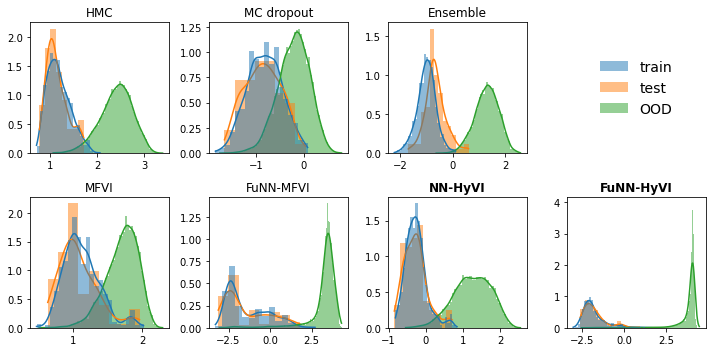

In [125]:
from pylab import *
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap

parameters = {'axes.labelsize':14,
              'axes.titlesize': 12,
              'xtick.labelsize' : 10,
              'ytick.labelsize' : 10,
              'figure.titlesize':14}
plt.rcParams.update(parameters)
Hs=torch.load(path+'_epist_VAR_10k.pt')

n_methods=len(methods)
fig,ax=plt.subplots(2,4,figsize=(10,5),squeeze=True)
ax=ax.flatten()
data_type=['train','test', 'OOD']#['train+test', 'OOD']
method_names=['MC dropout','Ensemble','MFVI','FuNN-MFVI','NN-HyVI','FuNN-HyVI']

split=1
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
d=0
for dataset in ['concrete']:
    m=0
    max_var=[]
    #ax.set_title(dataset)
    for method in methods:
        H_=Hs[dataset][method][split]
        H=[H_[0],H_[1], H_[2]]
        #for i in range(len(H)):
        #data=pd.DataFrame([pd.DataFrame(H[i].cpu(), columns=[data_type[i]]) for i in range(3)], columns=['type'])
        #print(data)
        #print(data)
 #       data=pd.concat([pd.Series(H[0].cpu(),name='train'),pd.Series(H[1].cpu(),name='test'),pd.Series(H[2].cpu(),name='OOD')], axis=0, join='inner')
#        print(data)
        print(method)
        
        for i in range(len(H)):
            max_var.append(H[i].max().cpu())
            sns.histplot(0.5*torch.log(2*math.pi*math.e*H[i]**2).cpu(), stat='density', lw=0,alpha = .5, kde=True, color=cmap(i), label=data_type[i],ax=ax[m], zorder=3-i)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],
            #sns.ecdfplot(H[i].pow(1).cpu(),color=cmap(i), label=data_type[i],ax=ax[m],lw=2, alpha=.7)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],

        if m==2: 
            handles, labels = ax[m].get_legend_handles_labels()
        
        ax[m].set_ylabel('')
        #ax[m].set_xlim(left=-4, right=4.5)
        #ax[m].set_ylim(bottom=0., top=4.)

        if d ==0:
            if method=='FuNN-HyVI' or method== 'NN-HyVI' or method== 'FuNN-HyVI*':
                ax[m].set_title(method, {'fontweight':'bold'})
            else:
                ax[m].set_title(method)
        m+=1
        if m==3:
            m+=1
#   for m in range(n_methods):
        #ax[m].set_ylim(bottom=0., top=1.1)


    d+=1
ax[3].set_axis_off()
ax[3].legend(handles, labels,frameon=False , loc='center', prop={'size': 14})

#ax[3,2].legend(loc='upper right', prop={'size': 8})#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()
#fig.align_ylabels(ax[:, 0])
plt.savefig(path+"_EpistGaussianEntropyDist_Exp1-{}.pdf".format(dataset), dpi=600)
#plt.subplots_adjust(top=.9)
#plt.suptitle('Posterior Predictive Entropy Distributions')
plt.show()

HMC
MC dropout
Ensemble
MFVI
FuNN-MFVI
NN-HyVI
FuNN-HyVI


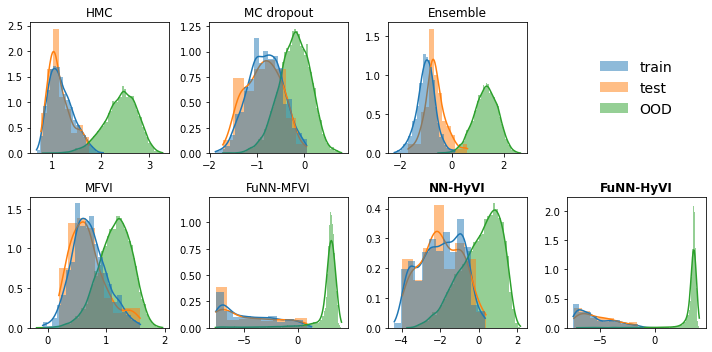

In [118]:
from pylab import *
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap

parameters = {'axes.labelsize':14,
              'axes.titlesize': 12,
              'xtick.labelsize' : 10,
              'ytick.labelsize' : 10,
              'figure.titlesize':14}
plt.rcParams.update(parameters)
Hs=torch.load(path+'_epist_H_10k.pt')

n_methods=len(methods)
fig,ax=plt.subplots(2,4,figsize=(10,5),squeeze=True)
ax=ax.flatten()
data_type=['train','test', 'OOD']#['train+test', 'OOD']
method_names=['MC dropout','Ensemble','MFVI','FuNN-MFVI','NN-HyVI','FuNN-HyVI']

split=1
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
d=0
for dataset in ['concrete']:
    m=0
    max_var=[]
    #ax.set_title(dataset)
    for method in methods:
        H_=Hs[dataset][method][split]
        H=[H_[0],H_[1], H_[2]]
        #for i in range(len(H)):
        #data=pd.DataFrame([pd.DataFrame(H[i].cpu(), columns=[data_type[i]]) for i in range(3)], columns=['type'])
        #print(data)
        #print(data)
 #       data=pd.concat([pd.Series(H[0].cpu(),name='train'),pd.Series(H[1].cpu(),name='test'),pd.Series(H[2].cpu(),name='OOD')], axis=0, join='inner')
#        print(data)
        print(method)
        
        for i in range(len(H)):
            max_var.append(H[i].max().cpu())
            sns.histplot(H[i].cpu(), stat='density', lw=0,alpha = .5, kde=True, color=cmap(i), label=data_type[i],ax=ax[m], zorder=3-i)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],
            #sns.ecdfplot(H[i].pow(1).cpu(),color=cmap(i), label=data_type[i],ax=ax[m],lw=2, alpha=.7)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],

        if m==2: 
            handles, labels = ax[m].get_legend_handles_labels()
        
        ax[m].set_ylabel('')
        #ax[m].set_xlim(left=-8, right=4.2)
        #ax[m].set_ylim(bottom=0., top=2.1)

        if d ==0:
            if method=='FuNN-HyVI' or method== 'NN-HyVI' or method== 'FuNN-HyVI*':
                ax[m].set_title(method, {'fontweight':'bold'})
            else:
                ax[m].set_title(method)
        m+=1
        if m==3:
            m+=1
#   for m in range(n_methods):
        #ax[m].set_ylim(bottom=0., top=1.1)


    d+=1
ax[3].set_axis_off()
ax[3].legend(handles, labels,frameon=False , loc='center', prop={'size': 14})

#ax[3,2].legend(loc='upper right', prop={'size': 8})#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()
#fig.align_ylabels(ax[:, 0])
plt.savefig(path+"_EpistVAR_dist_Exp1-{}.pdf".format(dataset), dpi=600)
#plt.subplots_adjust(top=.9)
#plt.suptitle('Posterior Predictive Entropy Distributions')
plt.show()

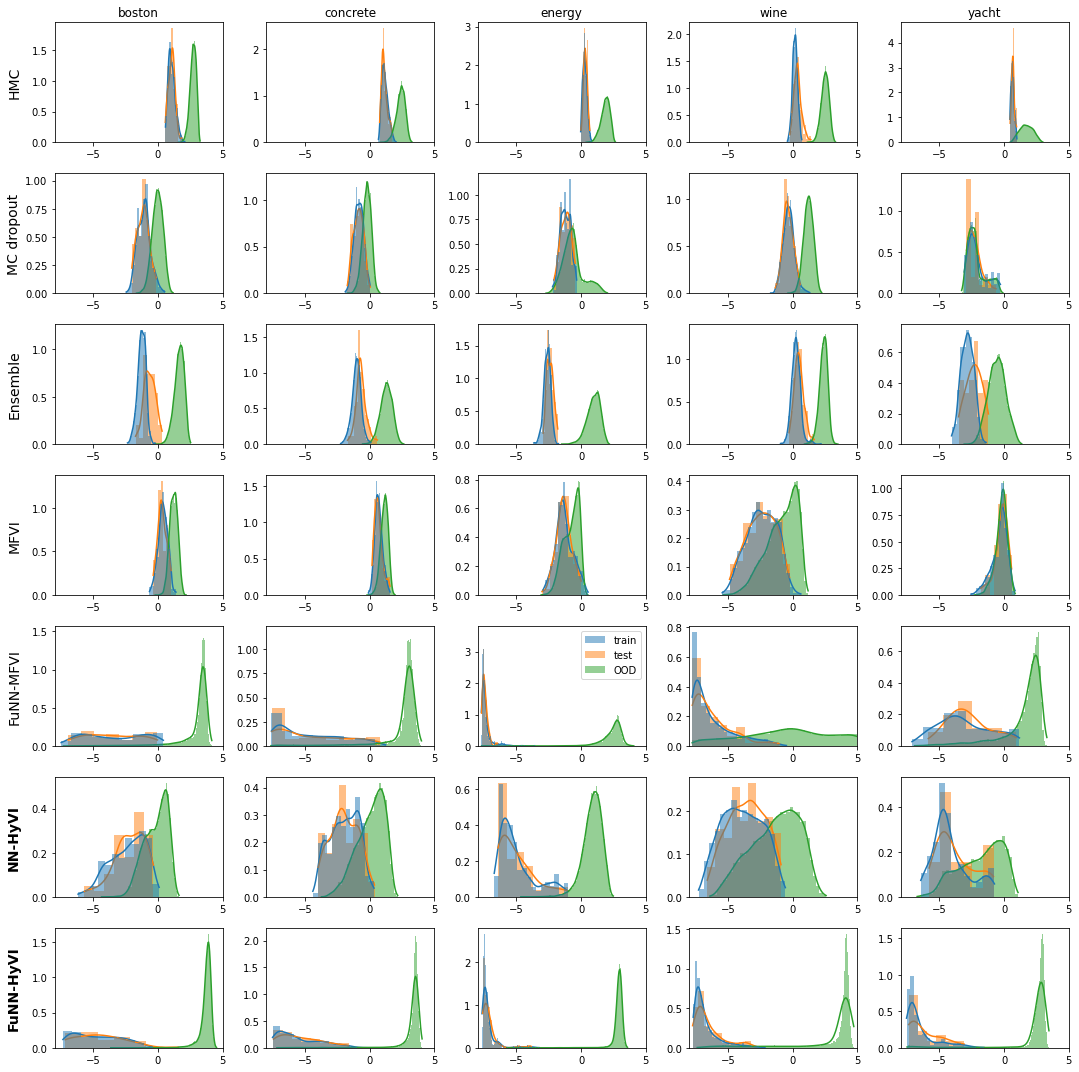

In [58]:
from pylab import *
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap

parameters = {'axes.labelsize':14,
              'axes.titlesize': 12,
              'xtick.labelsize' : 10,
              'ytick.labelsize' : 10,
              'figure.titlesize':14}
plt.rcParams.update(parameters)
Hs=torch.load(path+'_epist_H_10k.pt')
n_datasets=len(datasets)
n_methods=len(methods)
fig,ax=plt.subplots(n_methods,n_datasets,figsize=(15,15),squeeze=False)

data_type=['train','test', 'OOD']
#data_type=['train+test', 'OOD']
method_names=['MC dropout','Ensemble','MFVI','FuNN-MFVI','NN-HyVI','FuNN-HyVI']

split=1
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
d=0
for dataset in datasets:
    m=0
    max_var=[]
    ax[m,d].set_title(dataset)
    for method in methods:
        H_=Hs[dataset][method][split]
        H=[H_[0],H_[1], H_[2]]

        #for i in range(len(H)):
        #data=pd.DataFrame([pd.DataFrame(H[i].cpu(), columns=[data_type[i]]) for i in range(3)], columns=['type'])
        #print(data)
        #print(data)
 #       data=pd.concat([pd.Series(H[0].cpu(),name='train'),pd.Series(H[1].cpu(),name='test'),pd.Series(H[2].cpu(),name='OOD')], axis=0, join='inner')
#        print(data)
        for i in range(len(H)):
            max_var.append(H[i].max().cpu())
            sns.histplot(H[i].cpu(), stat='density', lw=0,alpha = .5, kde=True, color=cmap(i), label=data_type[i],ax=ax[m,d], zorder=3-i)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],
            #sns.ecdfplot(H[i].cpu(),color=cmap(i), label=data_type[i],ax=ax[m,d],lw=2, alpha=.7)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],

        if (m,d) == (4,2): 
            ax[m,d].legend()#.remove()
        ax[m,d].set_ylabel('')
        ax[m,d].set_xlim(left=-8, right=5)

        if d ==0:
            if method=='FuNN-HyVI' or method== 'NN-HyVI':
                ax[m,d].set_ylabel(method, {'fontweight':'bold'})
            else:
                ax[m,d].set_ylabel(method)
        m+=1
#     for m in range(n_methods):
#         ax[m,d].set_xlim(left=0., right=3)#np.max(max_var))

    d+=1
#ax[3,2].legend(loc='upper right', prop={'size': 8})#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()
fig.align_ylabels(ax[:, 0])
plt.savefig(path+"_EpistEntropyDist_-{}_scaled.pdf".format(split), dpi=600)
#plt.subplots_adjust(top=.9)
#plt.suptitle('Posterior Predictive Entropy Distributions')
plt.show()